# Data: Takeaway Food Orders
https://www.kaggle.com/datasets/henslersoftware/19560-indian-takeaway-orders/versions/4?resource=download<br>
인도 레스토랑 주문 데이터

## 영상참조
https://www.youtube.com/watch?v=Wsfz3i1AXzY

In [2]:
# pip install pandasql

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')
pysqldf = lambda q: sqldf(q, globals())

In [9]:
orders = pd.read_csv("./data/restaurant-1-orders.csv")
orders.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [10]:
orders.columns = ['number','timestamp','item','quantity','price','total_products_in_cart']
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [11]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart,date
34412,9185,13/04/2018 19:42,Special Fried Rice,1,3.95,8,2018-04-13
23174,8451,09/02/2018 11:57,Plain Rice,1,2.95,7,2018-09-02


In [12]:
print(f"Total number of orders in datasets: {orders['number'].nunique()}")

Total number of orders in datasets: 13397


In [13]:
def load_query(path):
    with open(path) as file:
        return file.read()

# case 1 : Direct multistep forecasting

In [22]:
query = load_query("./queries/daily_orders.sql")
daily_orders = pysqldf(query)

In [24]:
daily_orders.sample(3)

,date,num_orders
103,2016-06-11,12
1157,2019-07-17,7
297,2017-01-26,10


In [25]:
import logging
logging.getLogger().setLevel(logging.CRITICAL) # prevent the matplotlib infos on categorical x-axis, removable

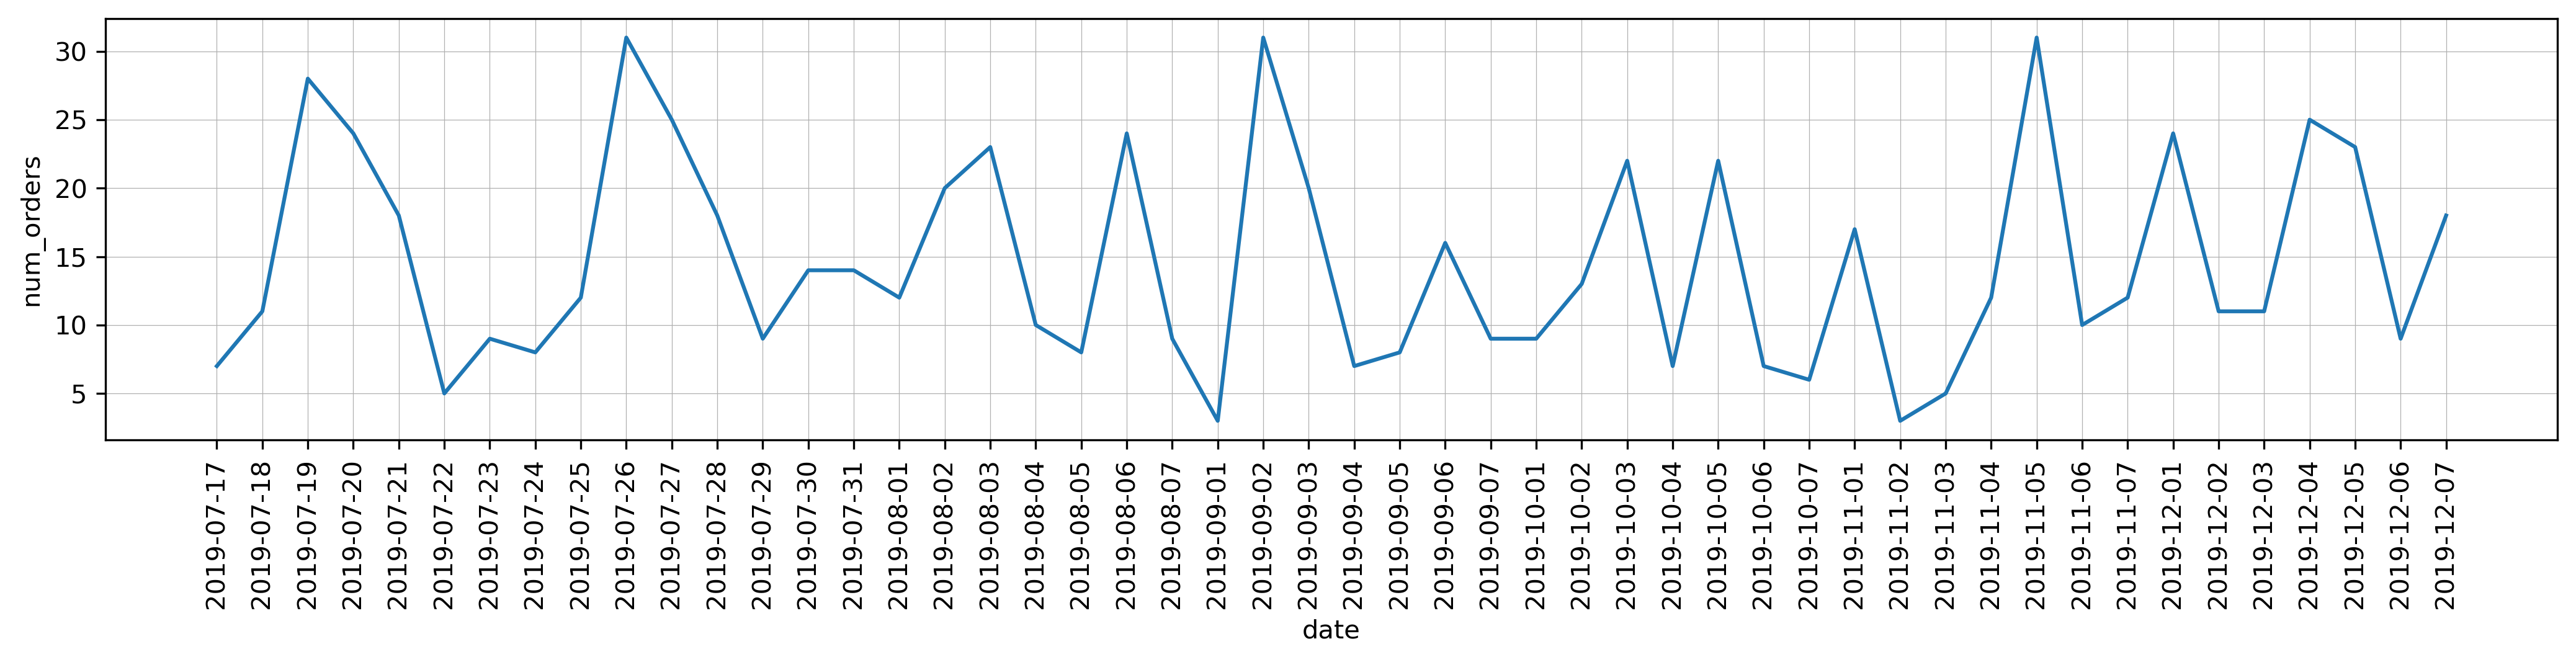

In [27]:
plt.rcParams.update({"figure.figsize": (17,3), "figure.dpi":300})
fig,ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y= 'num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [30]:
query = load_query("./queries/weekly_orders.sql")
weekly_orders = pysqldf(query)

In [32]:
weekly_orders.head()

,week,num_orders
0,2015-01-05,8
1,2015-02-09,5
2,2015-08-03,3
3,2015-09-07,6
4,2015-09-28,7


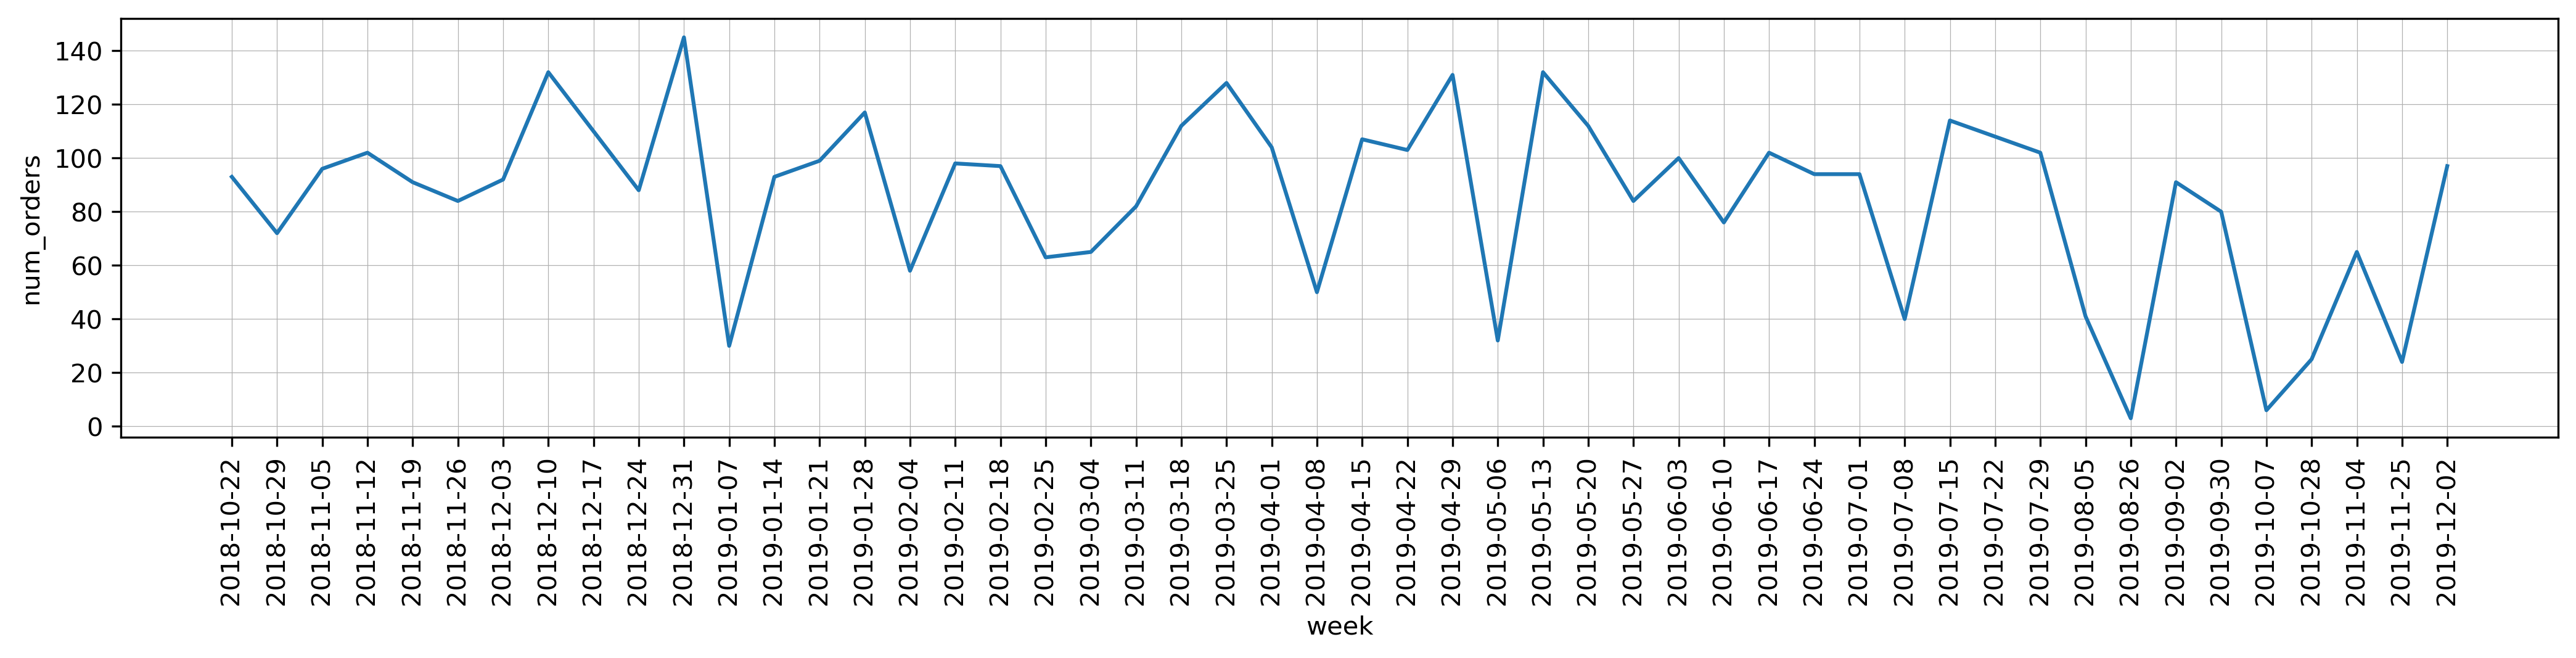

In [34]:
plt.rcParams.update({"figure.figsize": (17,3), "figure.dpi":300})
fig,ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y= 'num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [35]:
 len(weekly_orders)

196

# modeling
영상에서 특별한 계절성이 안보이기 때문에 과거 추세를 이용함<br>
쿼리가 어려워 정확하게 어떤 특성을 썼는지 알기 어려움<br>
추후 sql 공부를 더 할 예정

In [37]:
query = load_query('./queries/for_modeling.sql')
df = pysqldf(query)
df.head()

,week,order_count_7_day,order_count_30_day,label
0,2016-01-04,0,0,40
1,2016-01-11,40,40,17
2,2016-02-01,0,57,26
3,2016-02-08,26,66,42
4,2016-02-29,0,68,15


In [41]:
len(df)

190

In [38]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [40]:
from xgboost import XGBRegressor
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:68.79895	validation_1-mae:72.73834
[1]	validation_0-mae:68.12779	validation_1-mae:72.12849
[2]	validation_0-mae:67.46320	validation_1-mae:71.52456
[3]	validation_0-mae:66.80496	validation_1-mae:70.89914
[4]	validation_0-mae:66.15327	validation_1-mae:70.30691
[5]	validation_0-mae:65.50795	validation_1-mae:69.72041
[6]	validation_0-mae:64.86883	validation_1-mae:69.11307
[7]	validation_0-mae:64.23605	validation_1-mae:68.53793
[8]	validation_0-mae:63.60948	validation_1-mae:67.96838
[9]	validation_0-mae:62.98888	validation_1-mae:67.37858
[10]	validation_0-mae:62.37449	validation_1-mae:66.82005
[11]	validation_0-mae:61.76610	validation_1-mae:66.26697
[12]	validation_0-mae:61.16364	validation_1-mae:65.71925
[13]	validation_0-mae:60.56697	validation_1-mae:65.16515
[14]	validation_0-mae:59.97623	validation_1-mae:64.62994
[15]	validation_0-mae:59.39127	validation_1-mae:64.09995
[16]	validation_0-mae:58.81189	validation_1-mae:63.60182
[17]	validation_0-mae:58.23830	validation

[144]	validation_0-mae:18.93494	validation_1-mae:34.60605
[145]	validation_0-mae:18.79678	validation_1-mae:34.56417
[146]	validation_0-mae:18.66344	validation_1-mae:34.47000
[147]	validation_0-mae:18.53014	validation_1-mae:34.40189
[148]	validation_0-mae:18.40113	validation_1-mae:34.33145
[149]	validation_0-mae:18.26818	validation_1-mae:34.28966
[150]	validation_0-mae:18.14343	validation_1-mae:34.22350
[151]	validation_0-mae:18.01693	validation_1-mae:34.13347
[152]	validation_0-mae:17.89416	validation_1-mae:34.06844
[153]	validation_0-mae:17.77327	validation_1-mae:34.01891
[154]	validation_0-mae:17.65218	validation_1-mae:33.92647
[155]	validation_0-mae:17.53241	validation_1-mae:33.85499
[156]	validation_0-mae:17.41430	validation_1-mae:33.77951
[157]	validation_0-mae:17.29526	validation_1-mae:33.73865
[158]	validation_0-mae:17.18186	validation_1-mae:33.65255
[159]	validation_0-mae:17.06928	validation_1-mae:33.58545
[160]	validation_0-mae:16.95647	validation_1-mae:33.53713
[161]	validati

[286]	validation_0-mae:9.11327	validation_1-mae:30.69511
[287]	validation_0-mae:9.08013	validation_1-mae:30.69747
[288]	validation_0-mae:9.05462	validation_1-mae:30.68137
[289]	validation_0-mae:9.02031	validation_1-mae:30.68040
[290]	validation_0-mae:8.99476	validation_1-mae:30.67139
[291]	validation_0-mae:8.96982	validation_1-mae:30.65571
[292]	validation_0-mae:8.93634	validation_1-mae:30.65611
[293]	validation_0-mae:8.90445	validation_1-mae:30.65788
[294]	validation_0-mae:8.87966	validation_1-mae:30.64932
[295]	validation_0-mae:8.85540	validation_1-mae:30.63399
[296]	validation_0-mae:8.82418	validation_1-mae:30.63466
[297]	validation_0-mae:8.79516	validation_1-mae:30.63338
[298]	validation_0-mae:8.77065	validation_1-mae:30.62850
[299]	validation_0-mae:8.74594	validation_1-mae:30.62148
[300]	validation_0-mae:8.71531	validation_1-mae:30.62154
[301]	validation_0-mae:8.69070	validation_1-mae:30.61323
[302]	validation_0-mae:8.66767	validation_1-mae:30.60568
[303]	validation_0-mae:8.64519	

[430]	validation_0-mae:6.89358	validation_1-mae:30.14274
[431]	validation_0-mae:6.88426	validation_1-mae:30.13830
[432]	validation_0-mae:6.87761	validation_1-mae:30.13816
[433]	validation_0-mae:6.86831	validation_1-mae:30.13381
[434]	validation_0-mae:6.85955	validation_1-mae:30.13056
[435]	validation_0-mae:6.85300	validation_1-mae:30.13051
[436]	validation_0-mae:6.84548	validation_1-mae:30.12680
[437]	validation_0-mae:6.83857	validation_1-mae:30.12240
[438]	validation_0-mae:6.82963	validation_1-mae:30.12190
[439]	validation_0-mae:6.82116	validation_1-mae:30.11883
[440]	validation_0-mae:6.81256	validation_1-mae:30.11838
[441]	validation_0-mae:6.80531	validation_1-mae:30.11679
[442]	validation_0-mae:6.79861	validation_1-mae:30.11260
[443]	validation_0-mae:6.79243	validation_1-mae:30.11285
[444]	validation_0-mae:6.78393	validation_1-mae:30.11220
[445]	validation_0-mae:6.77735	validation_1-mae:30.10994
[446]	validation_0-mae:6.77091	validation_1-mae:30.10592
[447]	validation_0-mae:6.76399	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
predictions = reg.predict(X_test)
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

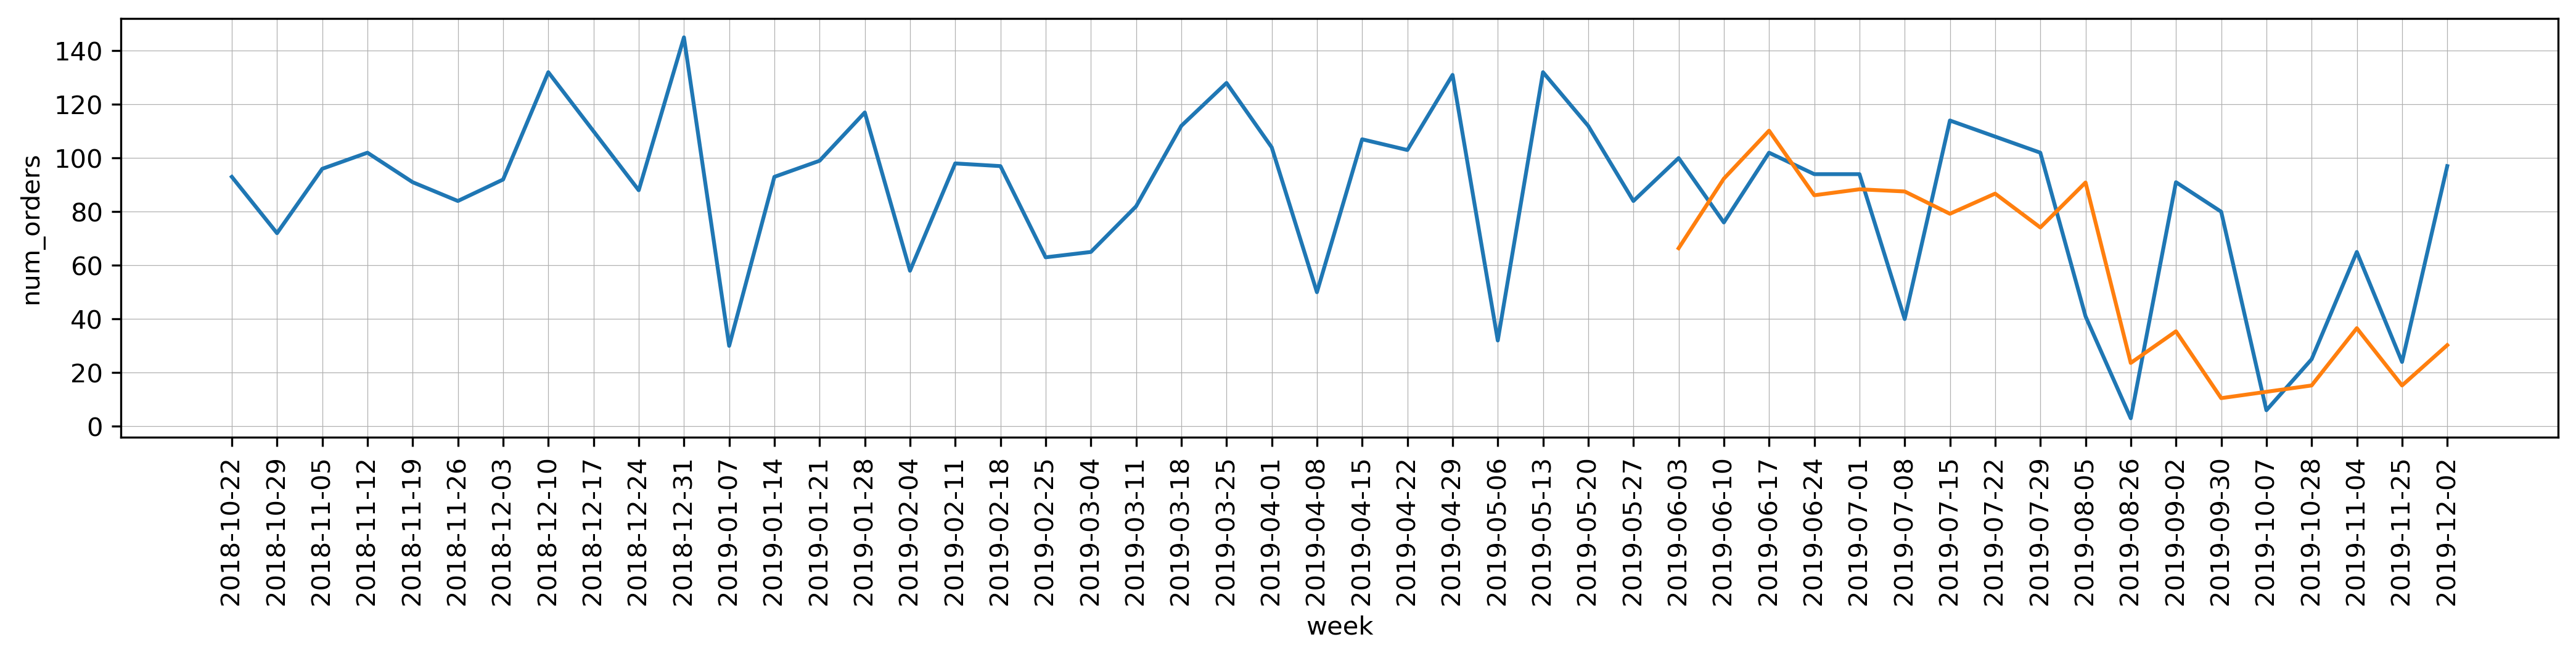

In [43]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)